In [0]:
%pip install unittest-xml-reporting
%pip install coverage

Python interpreter will be restarted.
Requirement already satisfied: unittest-xml-reporting in /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f4d65b5-cc4b-4e0d-911a-66de2ca684c1/lib/python3.8/site-packages (3.0.4)
WARNING: You are using pip version 20.2.4; however, version 21.2.4 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7f4d65b5-cc4b-4e0d-911a-66de2ca684c1/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.
Python interpreter will be restarted.
Requirement already satisfied: coverage in /local_disk0/.ephemeral_nfs/envs/pythonEnv-7f4d65b5-cc4b-4e0d-911a-66de2ca684c1/lib/python3.8/site-packages (5.5)
WARNING: You are using pip version 20.2.4; however, version 21.2.4 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-7f4d65b5-cc4b-4e0d-911a-66de2ca684c1/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
%run ./sample_tests

In [0]:
%run ./workflow_tests

In [0]:
%run ./dlt_workflow_refactored_unit_tests

In [0]:
%run ./dlt_workflow_refactored_integration_tests

In [0]:
import coverage.collector
import coverage
import coverage.python


should_trace = coverage.Coverage._should_trace
check_include_omit_etc = coverage.Coverage._check_include_omit_etc
get_python_source = coverage.python.get_python_source
reset = coverage.collector.Collector.reset

In [0]:
from typing import overload


def _find_code(name, lineno, names):
  def find_code(cells):
    if not lineno:
      return False
    cell_contents = cells[1]
    if not all(list(map(lambda x: cell_contents.find(str(x)), names))):
      return False
    lines = cell_contents.split("\n")
    if len(lines) < lineno:
      return False
    if name == "<module>":
      return lines[lineno-1].find(names[0]) != -1
    else:
      found = lines[lineno-1].strip().startswith(f"def {name}(")
      if not found:
        if lines[lineno-1].strip().startswith(f"@"):
          found = lines[lineno].strip().startswith(f"def {name}(")
      return found
  return find_code

cell_contents_map = {}
definitions_map = {}

def _should_trace(self, filename, frame):
    result = should_trace(self, filename=filename, frame=frame)
    if filename.startswith("<command-") and not frame.f_code.co_name == "<module>":
        result.trace = True
        result.reason = ""
        result.source_filename = filename
        code = list(filter(
          _find_code(
            frame.f_code.co_name, 
            frame.f_code.co_firstlineno, 
            frame.f_code.co_names
          ), 
          enumerate(globals()["In"])
        ))
        if code:
          cell_contents_map[filename] = code[0][0]          
          if code[0][1].split("\n")[frame.f_code.co_firstlineno-1].strip().startswith("@"):
            lines = set([frame.f_code.co_firstlineno, frame.f_code.co_firstlineno+1])
          else:
            lines = set([frame.f_code.co_firstlineno])
          filename = f"/databricks/driver/{filename}"
          if not definitions_map.get(filename):
            definitions_map[filename] = lines
          else:
            definitions_map[filename] |= lines
    elif (
      filename.startswith("/databricks") or 
      filename.startswith("/usr/local/lib/python3.8") or
      filename.startswith("/local_disk0/")
    ):
        result.trace = False
        result.reason = "Databricks library"
    return result


def _check_include_omit_etc(self, filename, frame):
    return check_include_omit_etc(self, filename=filename, frame=frame)
  
  
def _get_python_source(filename):
  if filename.startswith("/databricks/driver/<command-"):
    filename = filename.split("/")[-1]
    index = cell_contents_map.get(filename)
    if index is not None:
      return globals()["In"][index]
  return get_python_source(filename)


class protected_should_trace_cache(dict):
  def __init__(self, *args, **kwargs):    
    pass
  
  def __setitem__(self, key, value):
    pass

  def __getitem__(self, key):    
    return None
  
  def __delitem__(self, key):
    pass
  
  def __len__(self):
    return 0
  
  def __iter__(self):
    return {}
    
  def get(self, key, default=None):
    return None
  
  
def _reset(self):
  reset(self)
  self.should_trace_cache = protected_should_trace_cache()
  

setattr(coverage.Coverage, "_should_trace", _should_trace)
setattr(coverage.Coverage, "_check_include_omit_etc", _check_include_omit_etc)
setattr(coverage.collector.Collector, "reset", _reset)
coverage.python.get_python_source = _get_python_source

ctracer = coverage.collector.CTracer
coverage.collector.CTracer = None

In [0]:
import xml.etree.ElementTree as ET
import pandas as pd
import unittest
import xmlrunner
import uuid
import io
import datetime
import json

In [0]:
from inspect import getmro

def get_class_hierarchy(t):
  try:
    return getmro(t)
  except:
    return [object]

def run_tests():  
  test_classes = {t for t in globals().values() if unittest.case.TestCase in get_class_hierarchy(t) and t != unittest.case.TestCase}
  print(test_classes)

  loader = unittest.TestLoader()
  suite = unittest.TestSuite()
  for test_class in test_classes:
    tests = loader.loadTestsFromTestCase(test_class)
    suite.addTests(tests)

  out = io.BytesIO()
  runner = xmlrunner.XMLTestRunner(out)
  runner.run(suite)
  
  return out

In [0]:
def fixup_coverage_lines(c):  # pragma: no cover
  for k, v in cell_contents_map.items():
    lines = globals()["In"][v].split("\n")
    for i, line in enumerate(lines):
      if (
        line.strip().startswith("class") or
        line.strip().startswith("from") or
        line.strip().startswith("import")
      ):
        filename = f"/databricks/driver/{k}"
        if not definitions_map.get(filename):
          definitions_map[filename] = set([i+1])
        else:
          definitions_map[filename] |= set([i+1])
  cov._data.add_lines(definitions_map)

cov = coverage.Coverage()  # pragma: no cover
cov.start()                # pragma: no cover
test_output = run_tests()  # pragma: no cover
fixup_coverage_lines(cov)  # pragma: no cover
cov.stop()                 # pragma: no cover

{<class '__main__.FunctionUnitTests'>, <class '__main__.IntegrationTests'>, <class '__main__.WorkflowTests'>, <class '__main__.SampleTests'>}

Running tests...
----------------------------------------------------------------------
...............F.
======================================================================
FAIL [0.004s]: test_always_fails (__main__.SampleTests)
----------------------------------------------------------------------
Traceback (most recent call last):
 File "<command-3474342943506965>", line 10, in test_always_fails
 self.assertTrue(False)
AssertionError: False is not true

----------------------------------------------------------------------
Ran 17 tests in 13.435s

FAILED (failures=1)

Generating XML reports...

In [0]:
test_output.seek(0)
test_results = ET.XML(test_output.read().decode('utf-8'))

ts = []
for suite in test_results:
  for test in suite:
    failures = [{k:v for k,v in failure.items()} for failure in test]
    if len(failures) > 0:
      for failure in failures:
        attributes = {k:v for k,v in suite.attrib.items()}
        attributes.update({f"test_{k}":v for k,v in test.attrib.items()})
        attributes.update({f"failure_{k}":v for k,v in failure.items()})
        ts.append(attributes)
    else:
      attributes = {k:v for k,v in suite.attrib.items()}
      attributes.update({f"test_{k}":v for k,v in test.attrib.items()})
      attributes.update({"failure_type":None, "failure_message":None})
      ts.append(attributes)
    
df = pd.DataFrame(ts)
df["tests"] = df["tests"].astype(int)
df["errors"] = df["errors"].astype(int)
df["failures"] = df["failures"].astype(int)
df["skipped"] = df["skipped"].astype(int)
df["succeeded"] = df["tests"] - (df["errors"] + df["failures"] + df["skipped"])
df["name"] = df["name"].apply(lambda x: str.join("-", x.split("-")[:-1]))
df = df.loc[:, [
#   "timestamp", 
  "name", 
#   "time", 
  "tests", 
  "succeeded", 
  "errors", 
  "failures", 
  "skipped", 
  "test_name", 
  "test_time", 
  "failure_type", 
  "failure_message"
]]
df

Out[31]:

,name,tests,succeeded,errors,failures,skipped,test_name,test_time,failure_type,failure_message
0,FunctionUnitTests,6,6,0,0,0,test_add_ingest_columns,2.817,None,None
1,FunctionUnitTests,6,6,0,0,0,test_add_null_index_array,1.960,None,None
2,FunctionUnitTests,6,6,0,0,0,test_add_processed_timestamp,0.271,None,None
3,FunctionUnitTests,6,6,0,0,0,test_agg_count_by_country,1.988,None,None
4,FunctionUnitTests,6,6,0,0,0,test_filter_null_index_empty,0.424,None,None
5,FunctionUnitTests,6,6,0,0,0,test_filter_null_index_not_empty,0.425,None,None
6,IntegrationTests,5,5,0,0,0,test_bronze_airport_data,0.767,None,None
7,IntegrationTests,5,5,0,0,0,test_gold_airports_by_country,1.115,None,None
8,IntegrationTests,5,5,0,0,0,test_silver_airport_data,1.948,None,None
9,IntegrationTests,5,5,0,0,0,test_silver_airport_data_clean,0.671,None,None


Out[32]:

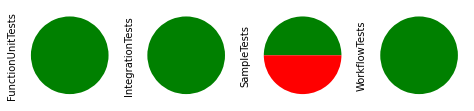

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e6a432be0>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7f4e6a410160>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7f4e6acd5af0>,
 <matplotlib.axes._subplots.AxesSubplot object at 0x7f4e6a369310>],
 dtype=object)

In [0]:
idx = df.groupby(["name", "tests", "succeeded", "errors", "failures", "skipped"]).first().index

gf = pd.DataFrame([[x for x in t] for t in idx], columns=idx.names)
gf.index = gf["name"]
gf = gf.iloc[:,2:]
gf.T.plot.pie(subplots=True, colors=['green', 'orange', 'red', 'yellow'], labeldistance=None, figsize=(8,8), legend=None)

Out[33]:

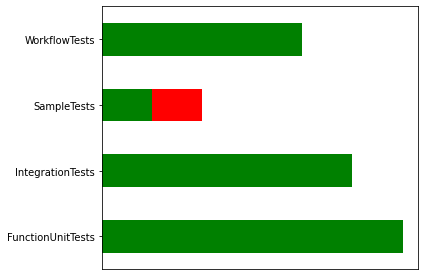

<matplotlib.axes._subplots.AxesSubplot at 0x7f4e6a1b82b0>

In [0]:
from matplotlib import pyplot as plt

plt.rcParams["figure.autolayout"] = True

group = df.groupby(["name"]).first()

group.loc[:, ["succeeded", "errors", "failures", "skipped"]].plot(kind="barh", stacked=True, color=['green', 'orange', 'red', 'yellow'], xticks=[], legend=None, xlabel="")

In [0]:
from coverage.xmlreport import XmlReporter
import io


with io.StringIO() as out:
  report = XmlReporter(cov)
  report.report(None, out)
  out.seek(0)
  xml = out.read()

In [0]:
from coverage.jsonreport import JsonReporter
import io


with io.StringIO() as out:
  report = JsonReporter(cov)
  report.report(None, out)
  out.seek(0)
  json = out.read()
  
print(json)

{"meta": {"version": "5.5", "timestamp": "2021-08-20T17:57:52.296606", "branch_coverage": false, "show_contexts": false}, "files": {"<command-2584907271439829>": {"executed_lines": [1, 4, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43], "summary": {"covered_lines": 30, "num_statements": 35, "percent_covered": 85.71428571428571, "missing_lines": 5, "excluded_lines": 0}, "missing_lines": [5, 6, 7, 8, 22], "excluded_lines": []}, "<command-2584907271439836>": {"executed_lines": [1, 2, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49, 50, 51, 52, 54, 55, 59, 60, 61, 62, 64, 65, 70, 71, 72, 73, 74, 75, 76, 77], "summary": {"covered_lines": 54, "num_statements": 54, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 0}, "missing_lines": [], "excluded_lines": []}, "<command-2677872462826267>": {"executed_lines": [1, 6, 7, 8, 11, 12, 13, 16, 17, 18, 25, 26, 27, 34, 35, 36], "summary": {"covered_lines": 16, "num_statements": 17, "percent_covered": 94.11764705882354, "missing_lines": 1, "excluded_lines": 0}, "missing_lines": [3], "excluded_lines": []}, "<command-3387135754555977>": {"executed_lines": [1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 23], "summary": {"covered_lines": 18, "num_statements": 18, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 0}, "missing_lines": [], "excluded_lines": []}, "<command-3387135754555978>": {"executed_lines": [1, 2, 3, 4, 5, 10, 11, 14, 15], "summary": {"covered_lines": 0, "num_statements": 0, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 16}, "missing_lines": [], "excluded_lines": [1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21]}, "<command-3474342943506741>": {"executed_lines": [1, 2, 3], "summary": {"covered_lines": 3, "num_statements": 7, "percent_covered": 42.857142857142854, "missing_lines": 4, "excluded_lines": 0}, "missing_lines": [4, 5, 6, 7], "excluded_lines": []}, "<command-3474342943506745>": {"executed_lines": [1, 2, 3, 4, 6, 7, 14, 16, 17, 18, 19], "summary": {"covered_lines": 11, "num_statements": 11, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 0}, "missing_lines": [], "excluded_lines": []}, "<command-3474342943506758>": {"executed_lines": [1, 2, 3, 4, 6, 7], "summary": {"covered_lines": 6, "num_statements": 7, "percent_covered": 85.71428571428571, "missing_lines": 1, "excluded_lines": 0}, "missing_lines": [5], "excluded_lines": []}, "<command-3474342943506760>": {"executed_lines": [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 19, 20], "summary": {"covered_lines": 16, "num_statements": 16, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 0}, "missing_lines": [], "excluded_lines": []}, "<command-3474342943506965>": {"executed_lines": [1, 2, 3, 4, 6, 7, 9, 10], "summary": {"covered_lines": 8, "num_statements": 8, "percent_covered": 100.0, "missing_lines": 0, "excluded_lines": 0}, "missing_lines": [], "excluded_lines": []}, "<command-3759169583448154>": {"executed_lines": [1, 2, 13, 14, 16, 17, 34, 35, 37, 38, 40, 41], "summary": {"covered_lines": 12, "num_statements": 14, "percent_covered": 85.71428571428571, "missing_lines": 2, "excluded_lines": 0}, "missing_lines": [5, 6], "excluded_lines": []}, "<command-4374004447560208>": {"executed_lines": [1, 2, 3, 29, 30, 37, 38, 41, 42, 43, 44, 45, 46, 49, 50, 53, 54, 57, 58], "summary": {"covered_lines": 19, "num_statements": 29, "percent_covered": 65.51724137931035, "missing_lines": 10, "excluded_lines": 0}, "missing_lines": [6, 9, 10, 26, 61, 62, 65, 66, 69, 70], "excluded_lines": []}, "<command-4374004447560260>": {"executed_lines": [1, 4, 5, 6, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], "summary": {"covered_lines": 40, "num_statements": 41, "percent_covered": 97.5609756097561, "missing_lines

In [0]:
setattr(coverage.Coverage, "_should_trace", should_trace)
setattr(coverage.Coverage, "_check_include_omit_etc", check_include_omit_etc)
setattr(coverage.collector.Collector, "reset", reset)
coverage.python.get_python_source = get_python_source

In [0]:
import pandas as pd

pdf = pd.read_json(json)

In [0]:
metadata = pdf.loc[["version", "timestamp", "branch_coverage", "show_contexts"], ["meta"]].T
metadata.index = [""]
metadata.T

Out[38]:

,
version,5.5
timestamp,2021-08-20T17:57:52.296606
branch_coverage,False
show_contexts,False


In [0]:
statistics = pdf.loc[["num_statements", "covered_lines", "missing_lines", "excluded_lines", "percent_covered"], ["totals"]].T
statistics.index = ["Results"]
statistics = statistics.T
statistics["Results"] = statistics["Results"].apply(lambda x: int(round(x, 0)))
statistics.columns = [""]
statistics

Out[39]:

,
num_statements,257
covered_lines,233
missing_lines,24
excluded_lines,16
percent_covered,91


In [0]:
from json import loads

files = pdf.drop(["version", "timestamp", "branch_coverage", "show_contexts", "covered_lines", "num_statements", "percent_covered", "missing_lines", "excluded_lines"]).drop(["meta", "totals"], axis=1)
files["file"] = files.index
files = files[
  files["file"].str[-1] == ">"
]
files.index = range(len(files.index))
files["executed_lines"] = files["files"].apply(lambda x: x.get("executed_lines"))
files["missing_lines"] = files["files"].apply(lambda x: x.get("missing_lines"))
files.loc[:, ["file", "executed_lines", "missing_lines"]]

Out[40]:

,file,executed_lines,missing_lines
0,<command-2584907271439829>,"[1, 4, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20,...","[5, 6, 7, 8, 22]"
1,<command-2584907271439836>,"[1, 2, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 18,...",[]
2,<command-2677872462826267>,"[1, 6, 7, 8, 11, 12, 13, 16, 17, 18, 25, 26, 2...",[3]
3,<command-3387135754555977>,"[1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, ...",[]
4,<command-3387135754555978>,"[1, 2, 3, 4, 5, 10, 11, 14, 15]",[]
5,<command-3474342943506741>,"[1, 2, 3]","[4, 5, 6, 7]"
6,<command-3474342943506745>,"[1, 2, 3, 4, 6, 7, 14, 16, 17, 18, 19]",[]
7,<command-3474342943506758>,"[1, 2, 3, 4, 6, 7]",[5]
8,<command-3474342943506760>,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 1...",[]
9,<command-3474342943506965>,"[1, 2, 3, 4, 6, 7, 9, 10]",[]


In [0]:
from json import loads

files = pdf.drop(["version", "timestamp", "branch_coverage", "show_contexts", "covered_lines", "num_statements", "percent_covered", "missing_lines", "excluded_lines"]).drop(["meta", "totals"], axis=1)
files = files[
  files.index.str[-1] == ">"
]
files["file"] = files.index
files["executed_lines"] = files["files"].apply(lambda x: x.get("executed_lines"))
files["missing_lines"] = files["files"].apply(lambda x: x.get("missing_lines"))
files["code"] = files["file"].apply(lambda x: globals()["In"][cell_contents_map.get(x)])

html = "<div style=\"width:850px;height:1100px;overflow-x:auto;overflow-y:auto;padding:20px;\"><table><thead><tr><th></th><th></th></tr></thead><tbody>"

for row in files.itertuples():
  filename = row.file.replace("<", "").replace(">", "").replace("-", "/")
  label = row.file.replace("<", "&lt;").replace(">", "&gt;")
  html += f"<tr><td colspan=\"2\" style=\"background-color:#eee;font-weight:bold;font-size:11pt;\">{label}</td></tr>"
  
  code = row.code.split("\n")  
  for i, line in enumerate(code):
    style = ""
    if (i+1) in row.executed_lines:
      style = "background-color:#cfc;"
    elif (i+1) in row.missing_lines:
      style = "background-color:#fcc;"
    html += f"<tr><td style=\"{style}\"><pre>{i+1}</pre></td><td style=\"{style}\"><pre>{line}</pre></td></tr>"
    
  html += "<tr><td colspan=\"2\"><pre>&nbsp;</pre></td></tr>"

html += "</tbody></table></div>"

displayHTML(html)

<command-2584907271439829> 1 import inspect 2 3 4 class DIContainer: 5 def __init__(self, **kwargs): 6 self.dependencies = {} 7 for k, v in kwargs.items(): 8 self._register(k, v) 9 10 def register(self, **kwargs): 11 for k, v in kwargs.items(): 12 self._register(k, v) 13 14 def resolve(self, key, *args, **kwargs): 15 value = self.dependencies.get(key) 16 if callable(value): 17 spec = inspect.getfullargspec(value) 18 args_dict = {} 19 for arg in spec[0]: 20 a = self.resolve(arg) 21 if a is not None: 22 args_dict[arg] = a 23 args_dict.update(kwargs) 24 return self._create_wrapper(value, spec[0], args, args_dict) 25 else: 26 return value 27 28 def _register(self, key, value): 29 self.dependencies[key] = value 30 self.__setattr__(f"get_{key}", lambda *a, **k: self.resolve(key, *a, **k)) 31 setattr(DIContainer, key, property(lambda s: self.resolve(key))) 32 33 @staticmethod 34 def _create_wrapper(x, spec, args_list, args_dict): 35 if [s for s in spec if s not in args_dict]: 36 def wrapper(*args): 37 args += args_list 38 return x(*args, **args_dict) 39 return wrapper 40 else: 41 def wrapper(): 42 return x(*args_list, **args_dict) 43 return wrapper   <command-2584907271439836> 1 from pyspark.sql.functions import when, col 2 from pyspark.sql import Row 3 4 5 class FunctionUnitTests(unittest.TestCase): 6 @classmethod 7 def setUpClass(cls): 8 container.register( 9 timestamp_provider=timestamp_provider 10 ) 11 12 def test_add_ingest_columns(self): 13 df = spark.range(1) 14 df = df.transform(container.add_ingest_columns) 15 result = df.collect() 16 self.assertEqual(1, len(result), "Only one record expected") 17 self.assertIn("ingest_timestamp", df.columns, "Ingest timestamp column not present") 18 self.assertIn("ingest_source", df.columns, "Ingest source column not present") 19 self.assertEqual(url.split("/")[-1], result[0].ingest_source, "Ingest source not correct") 20 self.assertEqual(timestamp, result[0].ingest_timestamp, "Ingest timestamp not correct") 21 22 def test_add_processed_timestamp(self): 23 df = spark.range(1) 24 df = df.transform(container.add_processed_timestamp) 25 result = df.collect() 26 self.assertEqual(1, len(result), "Only one record expected") 27 self.assertIn("processed_timestamp", df.columns, "Processed timestamp column not present") 28 self.assertEqual(timestamp, result[0].processed_timestamp, "Processed timestamp not correct") 29 30 def test_add_null_index_array(self): 31 df = spark.createDataFrame([ 32 Row(id=1, test_null=None), 33 Row(id=2, test_null=1) 34 ]) 35 df = df.transform(container.add_null_index_array) 36 result = df.collect() 37 self.assertEqual(2, len(result), "Two records are expected") 38 self.assertIn("nulls", df.columns, "Nulls column not present") 39 self.assertIsNone(result[0].test_null, "First record should contain null") 40 self.assertIsNotNone(result[1].test_null, "Second record should not contain null") 41 self.assertIn(1, result[0].nulls, "Nulls array should include 1") 42 self.assertIsNot(result[1].nulls, "Nulls array should be empty") 43 44 def test_filter_null_index_empty(self): 45 df = spark.createDataFrame([ 46 Row(id=1, test_null=None, nulls=[1]), 47 Row(id=2, test_null=1, nulls=[]) 48 ]) 49 df = df.transform(container.filter_null_index_empty) 50 result = df.collect() 51 self.assertEqual(1, len(result), "One record is expected") 52 self.assertNotIn("nulls", df.columns, "Nulls column not present") 53 54 def test_filter_null_index_not_empty(self): 55 df = spark.createDataFrame([ 56 Row(id=1, test_null=None, nulls=[1]), 57 Row(id=2, test_null=1, nulls=[]) 58 ]) 59 df = df.transform(container.filter_null_index_not_empty) 60 result = df.collect() 61 self.assertEqual(1, len(result), "One record is expected") 62 self.assertIn("nulls", df.columns, "Nulls column not present") 63 64 def test_agg_count_by_country(self): 65 df = spark.createDataFrame([ 66 Row(country="Country0"), 67 Row(country="Country1"), 68 Row(country="Country0") 69 ]) 70 df = df.transform(container.agg_count_by_country) 71

In [0]:
test_output.seek(0)
dbutils.notebook.exit(test_output.read().decode('utf-8'))

<?xml version="1.0" encoding="UTF-8"?>
<testsuites>
	<testsuite name="FunctionUnitTests-20210820175737" tests="6" file=".py" time="7.885" timestamp="2021-08-20T17:57:45" failures="0" errors="0" skipped="0">
		<testcase classname="FunctionUnitTests" name="test_add_ingest_columns" time="2.817" timestamp="2021-08-20T17:57:40"/>
		<testcase classname="FunctionUnitTests" name="test_add_null_index_array" time="1.960" timestamp="2021-08-20T17:57:42"/>
		<testcase classname="FunctionUnitTests" name="test_add_processed_timestamp" time="0.271" timestamp="2021-08-20T17:57:42"/>
		<testcase classname="FunctionUnitTests" name="test_agg_count_by_country" time="1.988" timestamp="2021-08-20T17:57:44"/>
		<testcase classname="FunctionUnitTests" name="test_filter_null_index_empty" time="0.424" timestamp="2021-08-20T17:57:45"/>
		<testcase classname="FunctionUnitTests" name="test_filter_null_index_not_empty" time="0.425" timestamp="2021-08-20T17:57:45"/>
	</testsuite>
	<testsuite name="IntegrationTests-2